In [ ]:
import openai
import pandas as pd
import numpy as np
import json
import time
from openai import OpenAI
import os

api_key = os.getenv("OPENAI_API_KEY")

# Set up OpenAI API key
client = OpenAI(api_key=api_key)

def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    response = client.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

df = pd.read_csv("ufc-master-analysis.csv").reset_index(drop=True)


# Ensure embeddings are correctly stored
df["blue embedding"] = df["Blue Fighter Analysis"].apply(lambda x: get_embedding(x.split("\n")[0]) if isinstance(x, str) else None)
df["red embedding"] = df["Red Fighter Analysis"].apply(lambda x: get_embedding(x.split("\n")[0]) if isinstance(x, str) else None)

# Save embeddings as JSON strings to avoid NaN-related issues
df["blue embedding"] = df["blue embedding"].apply(lambda x: json.dumps(x) if x is not None else None)
df["red embedding"] = df["red embedding"].apply(lambda x: json.dumps(x) if x is not None else None)

# Save as Parquet
df.to_parquet("fighter_analysis_with_embeddings.parquet", index=False)

df.head()


,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,RSubOdds,BSubOdds,RKOOdds,BKOOdds,RED_ELO_BEFORE,BLUE_ELO_BEFORE,Red Fighter Analysis,Blue Fighter Analysis,blue embedding,red embedding
0,Brandon Royval,Tatsuro Taira,NaN,NaN,NaN,NaN,12/10/2024,"Las Vegas, Nevada, USA",USA,Red,...,NaN,NaN,NaN,NaN,1270.69,1271.43,Brandon Royval is known for his dynamic and un...,Tatsuro Taira is a well-rounded fighter known ...,"[-0.029179174453020096, 0.001777016674168408, ...","[-0.018833812326192856, 0.05696612969040871, 0..."
1,Brad Tavares,JunYong Park,NaN,NaN,NaN,NaN,12/10/2024,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,NaN,NaN,NaN,1125.38,1069.18,Brad Tavares exhibits a balanced fighting styl...,JunYong Park is a well-rounded fighter with a ...,"[-0.04011671617627144, 0.015213902108371258, -...","[-0.025361455976963043, 0.005301446653902531, ..."
2,Chidi Njokuani,Jared Gooden,NaN,NaN,NaN,NaN,12/10/2024,"Las Vegas, Nevada, USA",USA,Red,...,NaN,NaN,NaN,NaN,1020.97,974.77,Chidi Njokuani is a striking specialist known ...,Jared Gooden is a welterweight fighter known f...,"[-0.0042653512209653854, 0.02764534205198288, ...","[-0.012185238301753998, 0.03421642631292343, -..."
3,Grant Dawson,Rafa Garcia,-380.0,300.0,26.3158,300.0,12/10/2024,"Las Vegas, Nevada, USA",USA,Red,...,350.0,1600.0,900.0,800.0,1309.04,1128.61,Grant Dawson is known for his grappling-heavy ...,Rafa Garcia is a grappling-heavy fighter with ...,"[-0.017532510682940483, 0.06735983490943909, 0...","[0.011499815620481968, 0.0214033592492342, 0.0..."
4,Daniel Rodriguez,Alex Morono,-245.0,200.0,40.8163,200.0,12/10/2024,"Las Vegas, Nevada, USA",USA,Red,...,1100.0,1200.0,215.0,1000.0,1131.20,1104.60,Daniel Rodriguez is a versatile striker known ...,Alex Morono employs a well-rounded fighting st...,"[-0.029289156198501587, 0.06183266639709473, 0...","[-0.013586645945906639, 0.015352419577538967, ..."


In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import ast

df = pd.read_parquet("fighter_analysis_with_embeddings.parquet")

df = df.dropna(subset=['blue embedding', "red embedding"])
#df.to_parquet("ufc-master-embedding-long.parquet")

# Convert string to list
df['blue embedding'] = df['blue embedding'].apply(ast.literal_eval)
df['red embedding'] = df['red embedding'].apply(ast.literal_eval)
print(df.shape)

df_blue = pd.DataFrame(df['blue embedding'].tolist())
df_blue.columns = [f'blue_emb_{i}' for i in range(df_blue.shape[1])]
print(f"blue df shape: {df_blue.shape}")

df_red = pd.DataFrame(df['red embedding'].tolist())
df_red.columns = [f'red_emb_{i}' for i in range(df_red.shape[1])]
print(f"red df shape: {df_red.shape}")



 

(6437, 55)
blue df shape: (6437, 1536)
red df shape: (6437, 1536)


[3.89912999e-02 3.24763117e-02 2.75667783e-02 ... 2.09631626e-07
 1.98747699e-07 1.85527868e-07]


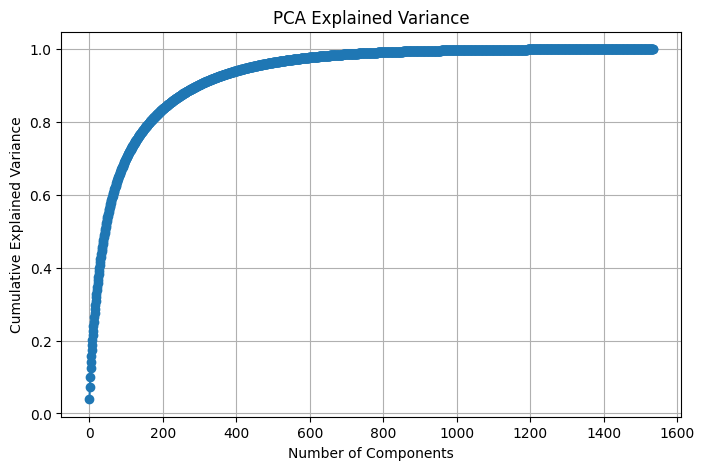

Optimal number of components: 166


In [3]:
# Plot the cumulative explained variance
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
scaled_blue = scaler.fit_transform(df_blue)


pca_full = PCA()
pca_full.fit(scaled_blue)

# Print the explained variance ratio of each component
print(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()


explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
# Find the number of components that explain at least 95% variance
num_components = np.argmax(explained_variance >= 0.80) + 1
print(f"Optimal number of components: {num_components}")



variance of 95% requires 436 components
90% 295
85% 217
80% 166
I might select 200 as it will be 83% approx.

In [44]:
print(f"df: {df.shape}")
print(f"df blue: {df_blue.shape}")

scaler = StandardScaler()
scaled_blue = scaler.fit_transform(df_blue)
scaled_red = scaler.fit_transform(df_red)



pca = PCA(n_components=200)
principal_components_blue = pca.fit_transform(scaled_blue)
principal_components_red = pca.fit_transform(scaled_red)
#df_final = pd.read_parquet("ufc-master-embedding-long.parquet")
#df_final = df_final.dropna(subset=['blue embedding', "red embedding"])
# Convert back to a DataFrame
df_pca_blue = pd.DataFrame(principal_components_blue)
df_pca_red = pd.DataFrame(principal_components_red)


df = df.reset_index(drop=True)
pca_df_red = df_pca_red.reset_index(drop=True)
pca_df_red.columns = [f'red_{i}' for i in pca_df_red.columns]
pca_df_blue = df_pca_blue.reset_index(drop=True)
pca_df_blue.columns = [f'blue_{i}' for i in pca_df_blue.columns]
print(pca_df_blue.columns)

df_pca = pd.concat([df, pca_df_red, pca_df_blue], axis=1)
print(f"pca shape after concat: {df_pca.shape}")

df_pca.tail(10)
df_pca.to_parquet("ufc-master-pca.parquet", index=False)

df: (6437, 55)
df blue: (6437, 1536)
Index(['blue_0', 'blue_1', 'blue_2', 'blue_3', 'blue_4', 'blue_5', 'blue_6',
       'blue_7', 'blue_8', 'blue_9',
       ...
       'blue_190', 'blue_191', 'blue_192', 'blue_193', 'blue_194', 'blue_195',
       'blue_196', 'blue_197', 'blue_198', 'blue_199'],
      dtype='object', length=200)
pca shape after concat: (6437, 455)


In [37]:
df.to_parquet("ufc-master-pca.parquet", index=False)